## Within-questionnaire slope model

In [1]:
import glob
import re
from nilearn.glm.second_level import SecondLevelModel
import pandas as pd
import nibabel as nf

In [2]:
root = '/oak/stanford/groups/russpold/data/uh2/aim1'
activation_map_path = f'{root}/derivatives/output_surveyMedley_noderivs_rerun/surveyMedley_lev1_output/task_surveyMedley_rtmodel_rt_duration/contrast_estimates'
activation_maps = glob.glob(f'{activation_map_path}/*')

sub_ids = sorted(set([re.search('_sub_(.*)_rtmodel_rt_duration_stat_contrast.nii.gz', val).group(1) for val in activation_maps]))
# exclude the subjects who contribute to the most dropout in the group mask (this was determined earlier by Jeanette)
excluded_subject_ids = ['234', '445']
sub_ids = [sub for sub in sub_ids if sub not in excluded_subject_ids]

# Load events files
events_files = sorted(glob.glob(f'{root}/BIDS/sub-s*/ses-[0-9]/func/*surveyMedley*modified*.tsv'))

grit_questions = ["Q01", "Q02", "Q03", "Q04", "Q05", "Q06", "Q07", "Q08"]
brief_questions = ["Q09", "Q10", "Q11", "Q12", "Q13", "Q14", "Q15", "Q16", "Q17", "Q18", "Q19", "Q20", "Q21"]
future_time_questions = ["Q22", "Q23", "Q24", "Q25", "Q26", "Q27", "Q28", "Q29", "Q30", "Q31"]
upps_questions = ["Q32", "Q33", "Q34", "Q35", "Q36", "Q37"]
impulsive_venture_questions = ["Q38", "Q39", "Q40"]
questionnaires = {"grit": grit_questions, "brief": brief_questions, "future_time": future_time_questions, "upps": upps_questions, "impulsive_venture": impulsive_venture_questions}

In [8]:
def get_sub_event_file(sub_id, events_files):
    for file in events_files:
        if sub_id in file:
            return file

In [11]:
for sub in sub_ids:
    sub_event_file = get_sub_event_file(sub, events_files)
    df = pd.read_csv(sub_event_file, sep='\t')
    # Get behavioral and bold data for each questionnaire
    behavior_dict = {"grit": [], "brief": [], "future_time": [], "upps": [], "impulsive_venture": []}
    bold_dict = {"grit": [], "brief": [], "future_time": [], "upps": [], "impulsive_venture": []}
    num_responses = 0
    for questionnaire in questionnaires:
        for question in questionnaires[questionnaire]:
            response = df.loc[df['trial_type'] == question, 'coded_response']
            behavior = response.values[0]
            if not pd.isna(behavior):
                question_bold_file = f'{activation_map_path}/task_surveyMedley_contrast_{question}_v_baseline_sub_{sub}_rtmodel_rt_duration_stat_contrast.nii.gz'
                if question_bold_file in activation_maps:
                    bold_dict[questionnaire].append(question_bold_file)
                    behavior_dict[questionnaire].append(behavior)
                    num_responses += 1
    # Make design matrix
    design_matrix = pd.DataFrame()
    # First columns are dummy regressors for each questionnaire with 3 or more responses
    start = 0
    for questionnaire in questionnaires:
        if(len(behavior_dict[questionnaire]) >= 3):
            one_indices = list(range(start, len(behavior_dict[questionnaire]) + start))
            start = one_indices[-1] + 1
            col = [1 if i in one_indices else 0 for i in range(num_responses)]
            design_matrix[questionnaire] = col
    # Other columns are questionnaire-specific behavioral regressors
    start = 0
    for questionnaire in questionnaires:
        if(len(behavior_dict[questionnaire]) >= 3):
            one_indices = list(range(start, len(behavior_dict[questionnaire]) + start))
            start = one_indices[-1] + 1
            col = [behavior_dict[questionnaire][i - one_indices[0]] if i in one_indices else 0 for i in range(num_responses)]
            design_matrix[f'{questionnaire}_responses'] = col
    all_zeros_rows_count = (design_matrix == 0).all(axis=1).sum()
    design_matrix = design_matrix.loc[(design_matrix!=0).any(axis=1)] 
    for i in range(all_zeros_rows_count):
        bold_dict["impulsive_venture"].pop(-1)

    # generate a contrast map for each questionnaire
    model = SecondLevelModel(n_jobs=2)
    sub_bold_files = []
    for questionnaire in questionnaires:
        sub_bold_files = sub_bold_files + bold_dict[questionnaire]
    model.fit(sub_bold_files, design_matrix=design_matrix)
    for i in range(int(design_matrix.shape[1] / 2)):
        contrast_map = model.compute_contrast(second_level_contrast=design_matrix.columns[i], output_type='effect_size')
        nf.save(contrast_map, f'{root}/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/within_subject_results/{design_matrix.columns[i]}_behavioral_measures_effect_size_sub_{sub}.nii.gz')

0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
1
0
0
0
0
2
2
0
0
0
0
0
0
0
0
1
0
0
0
2
0
0
0
0
0
0
0
0
0
0
2
0
0
0
2
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
2
0
2
0
0
2
2
0
0
2
0
0
0
0
0
0
0
0
1
0


## Group analysis

Run the within-questionnaire group averages.

In [3]:
from nilearn import plotting

In [4]:
def second_level_model_group_averages(bold_files, contrast):
  # extract only the files for the contrast
  contrast_bold_files = [file for file in bold_files if contrast in file]

  design_matrix = pd.DataFrame(
      [1] * len(contrast_bold_files),
      columns=['intercept'],
  )
  model = SecondLevelModel(n_jobs=2)
  model.fit(contrast_bold_files, design_matrix=design_matrix)
  z_map = model.compute_contrast('intercept', output_type='z_score')
  return z_map

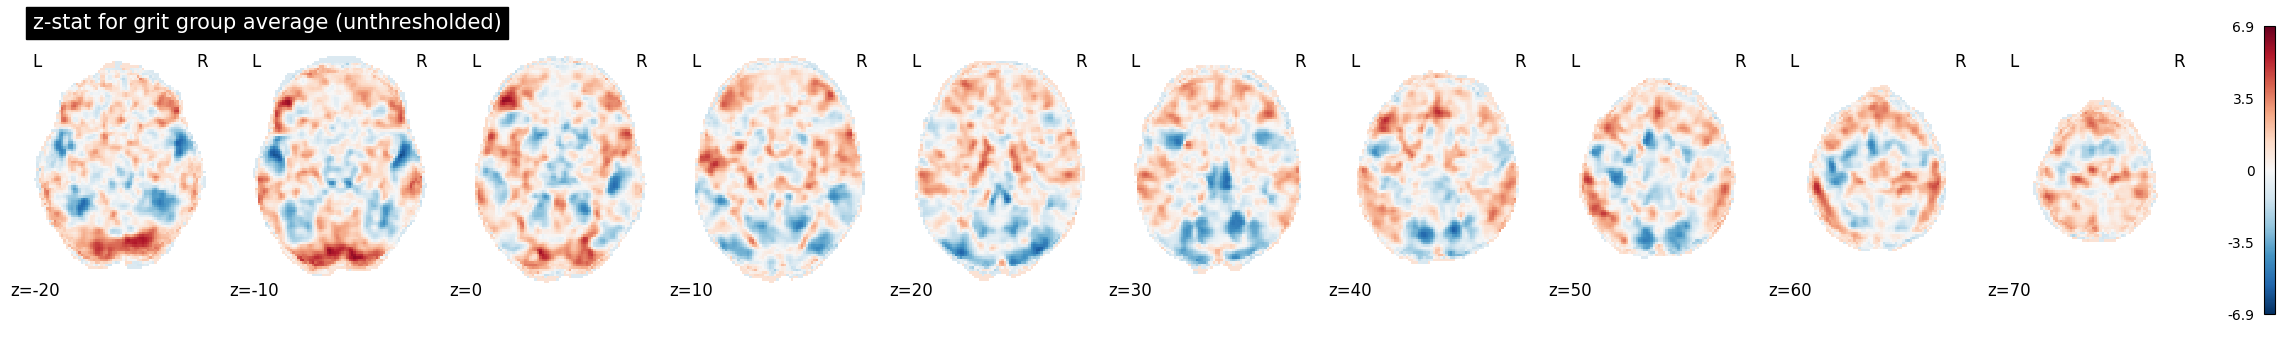

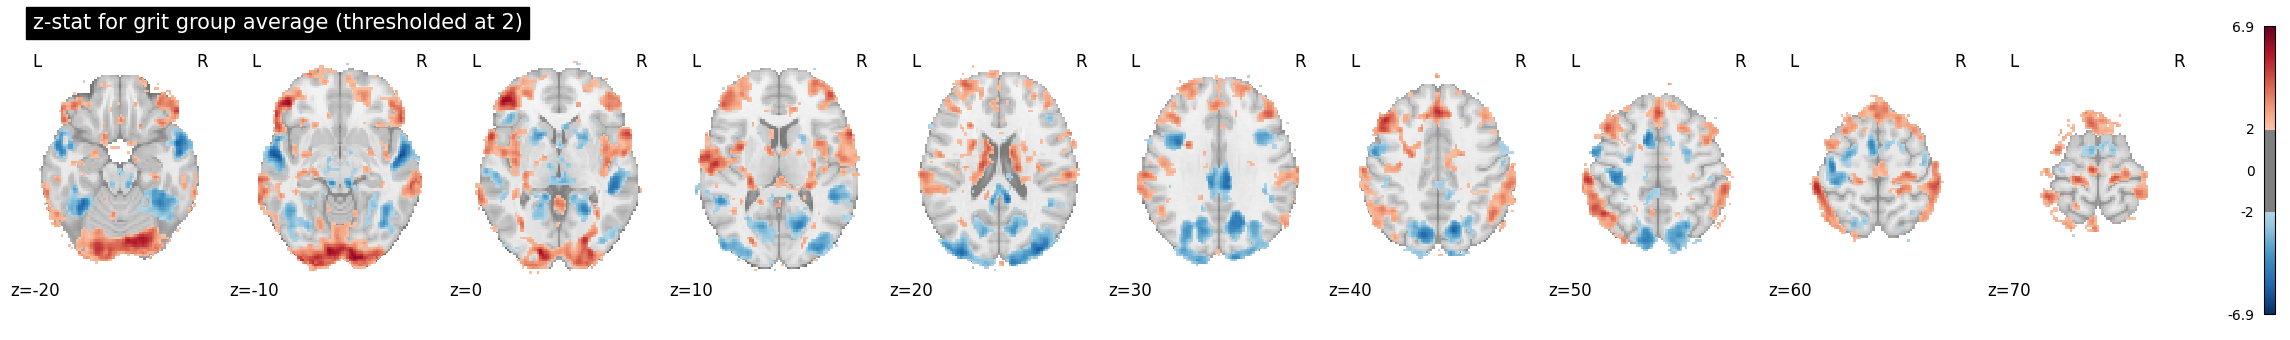

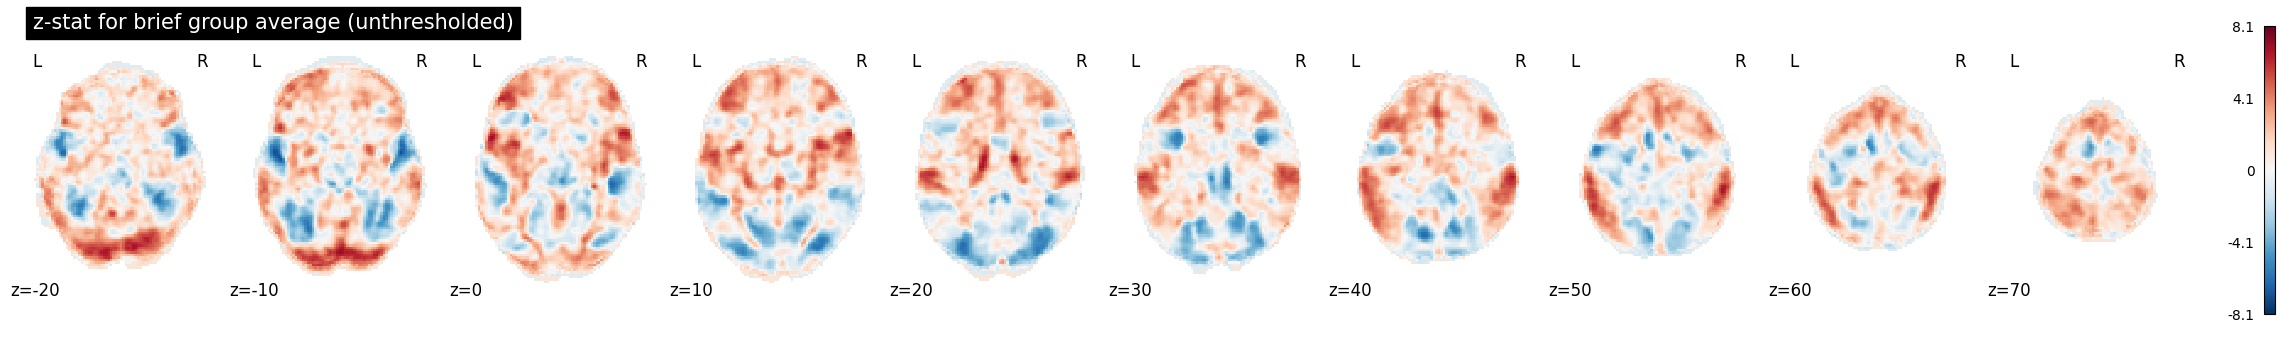

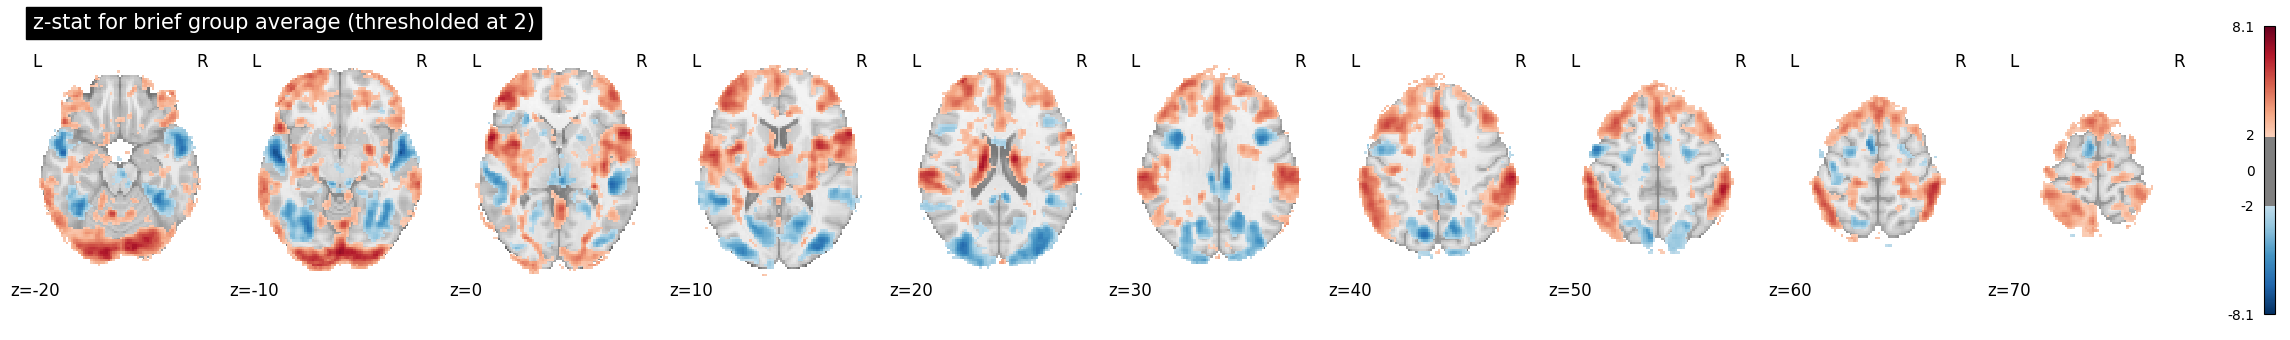

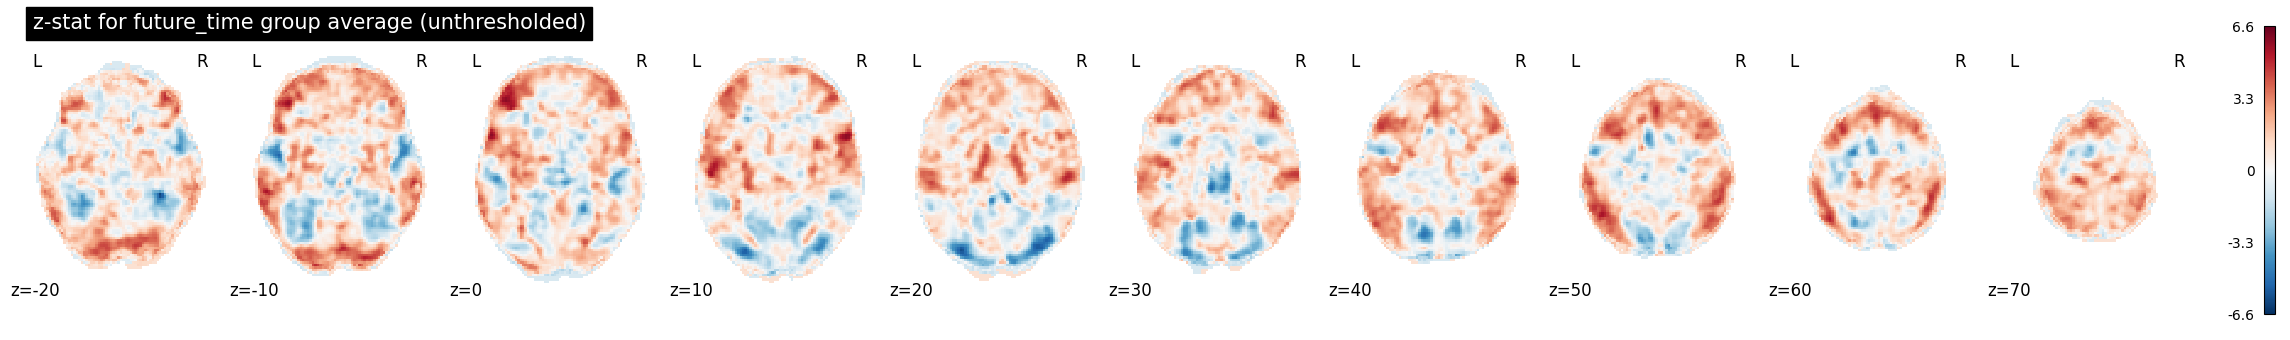

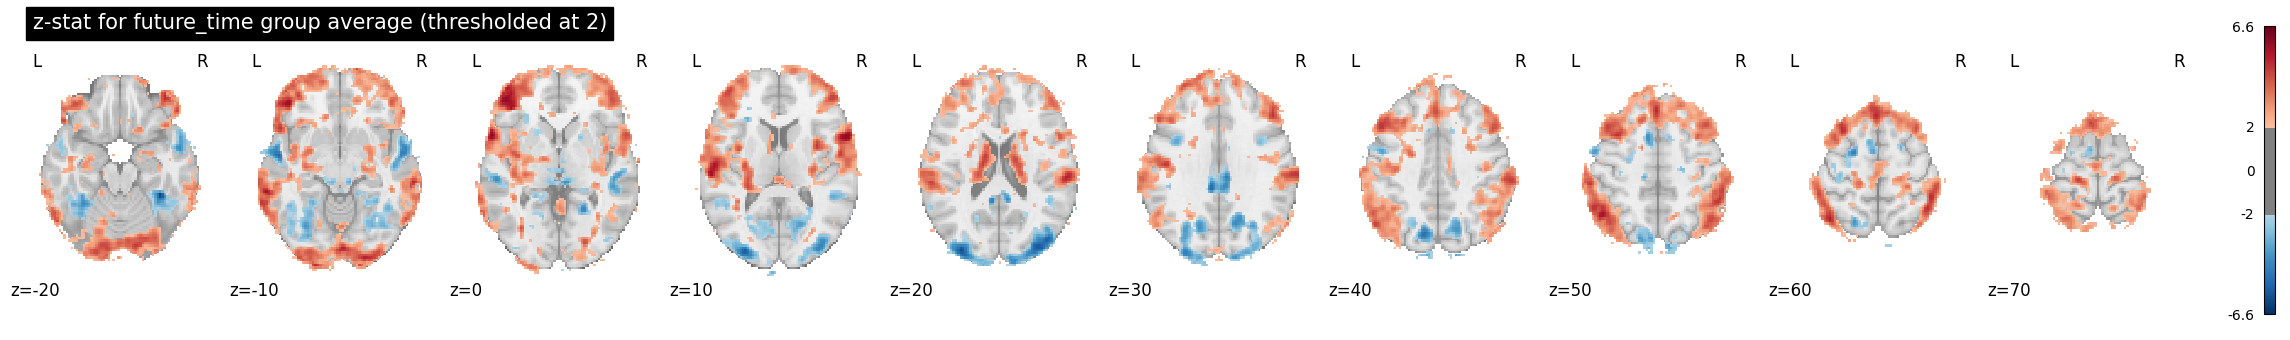

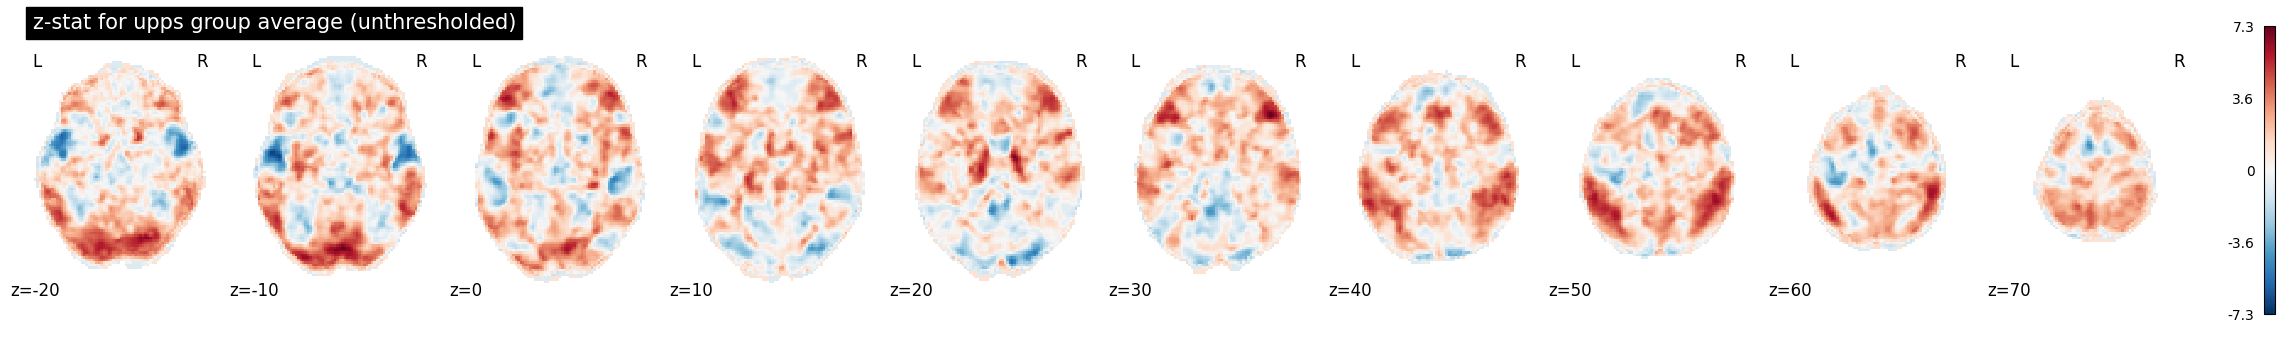

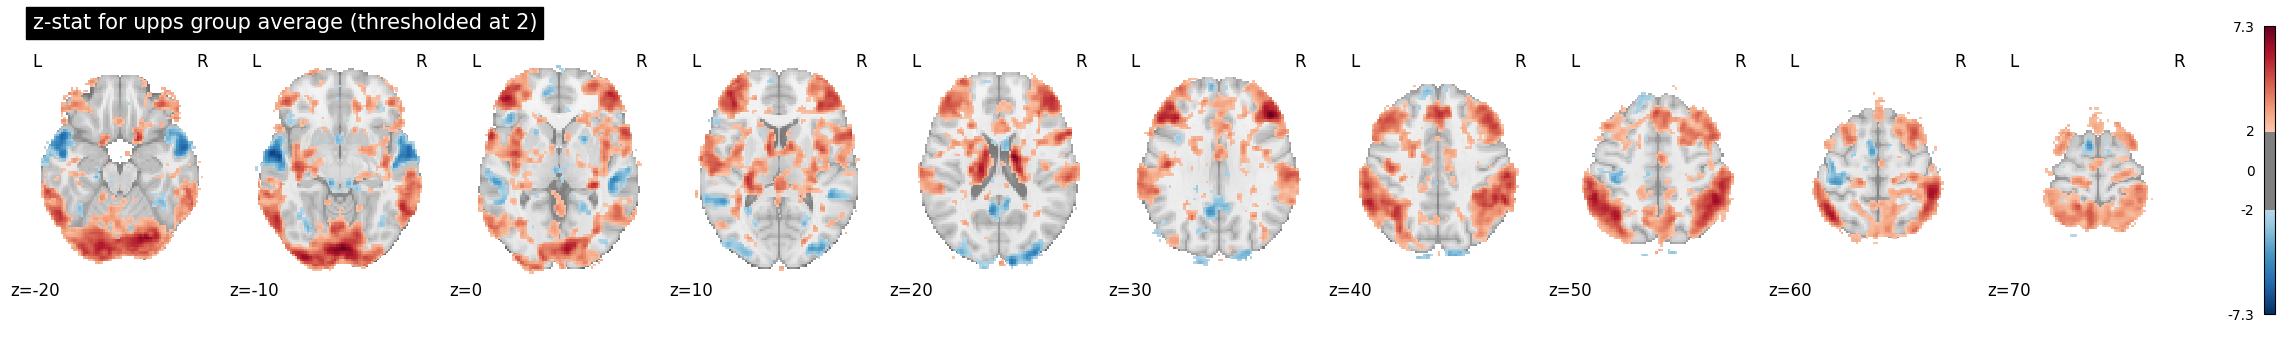

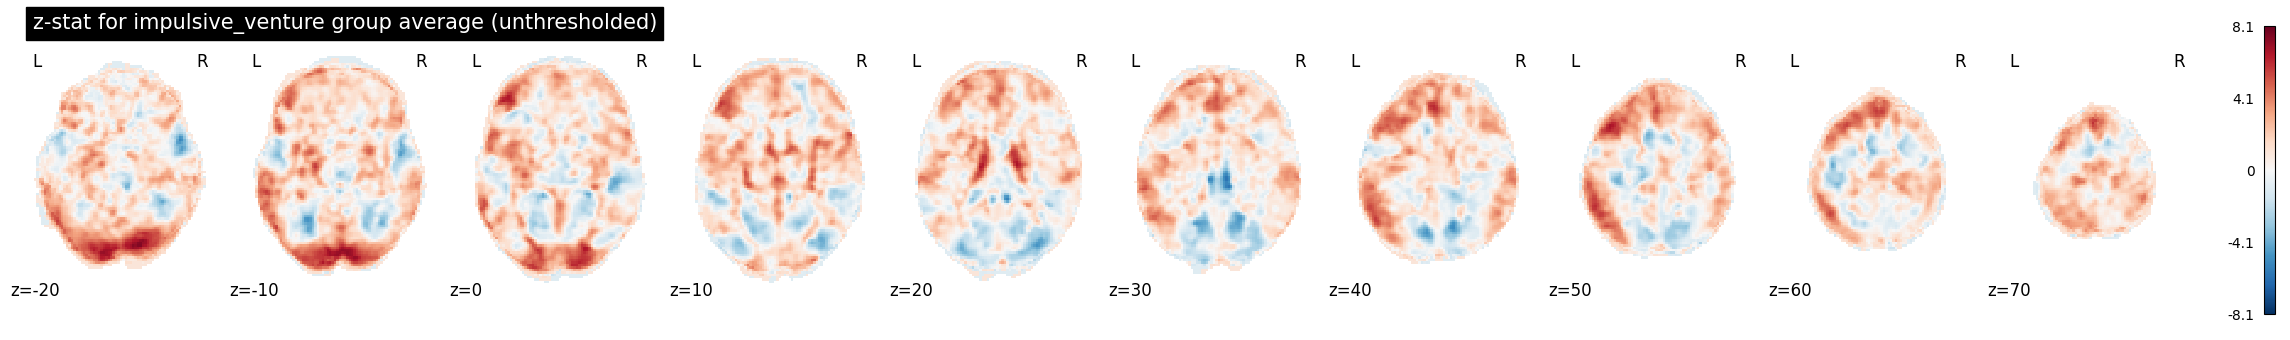

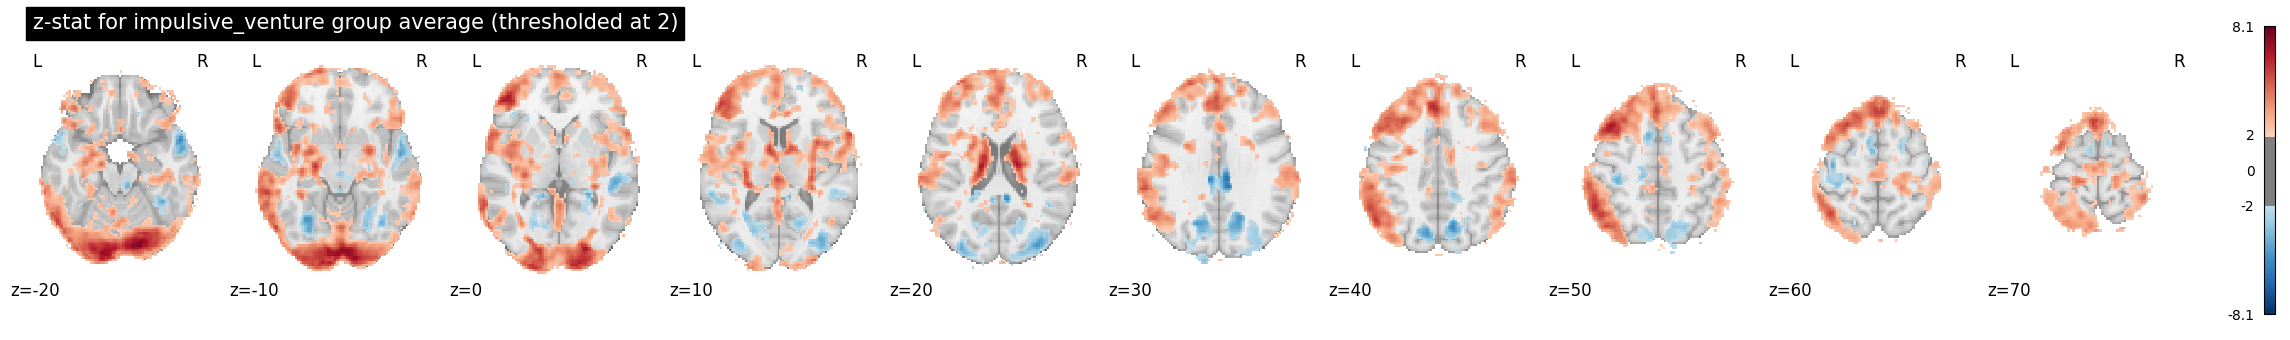

In [8]:
output_dir = f"{root}/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/within_subject_results"
subject_contrasts = sorted(glob.glob(f"{output_dir}/*"))
contrasts = ["grit", "brief", "future_time", "upps", "impulsive_venture"]
z_slices = [-20, -10, 0, 10, 20, 30, 40, 50, 60, 70]

# exclude contrasts past threshold of > 8% voxels above +/- 3SD above subject-specific mean
outlier_file = pd.read_csv(f"{root}/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/behavioral_measures_effect_size_outlier_analysis/percent_outlier_data.csv")
outlier_file = outlier_file[outlier_file["image_outlier_percentage"] >= 8]
outlier_contrasts = []
for index, row in outlier_file.iterrows():
  contrast_name = row['contrast_name']
  sub_id = str(row['subject_label']).zfill(3)
  outlier_contrasts.append(f"{output_dir}/{contrast_name}_behavioral_measures_effect_size_sub_{sub_id}.nii.gz")
subject_contrasts = [file for file in subject_contrasts if file not in outlier_contrasts]

# run the group average for each contrast and plot the result
for contrast in contrasts:
  z_map = second_level_model_group_averages(subject_contrasts, contrast)
  nf.save(z_map, f"{root}/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/{contrast}_group_average/{contrast}_group_average.nii.gz")
  plotting.plot_stat_map(
            z_map,
            display_mode='z',
            cut_coords=z_slices,
            colorbar=True,
            title=f'z-stat for {contrast} group average (unthresholded)'
        )
  plotting.show()
  plotting.plot_stat_map(
            z_map,
            display_mode='z',
            cut_coords=z_slices,
            colorbar=True,
            threshold=2.0, 
            title=f'z-stat for {contrast} group average (thresholded at 2)'
        )
  plotting.show()
  
  

Run an F-test comparing all {questionnaire} vs. grit regressors.

In [3]:
from randomise_prep import setup_randomise_tfce
from nilearn import masking
from nilearn.plotting import plot_design_matrix

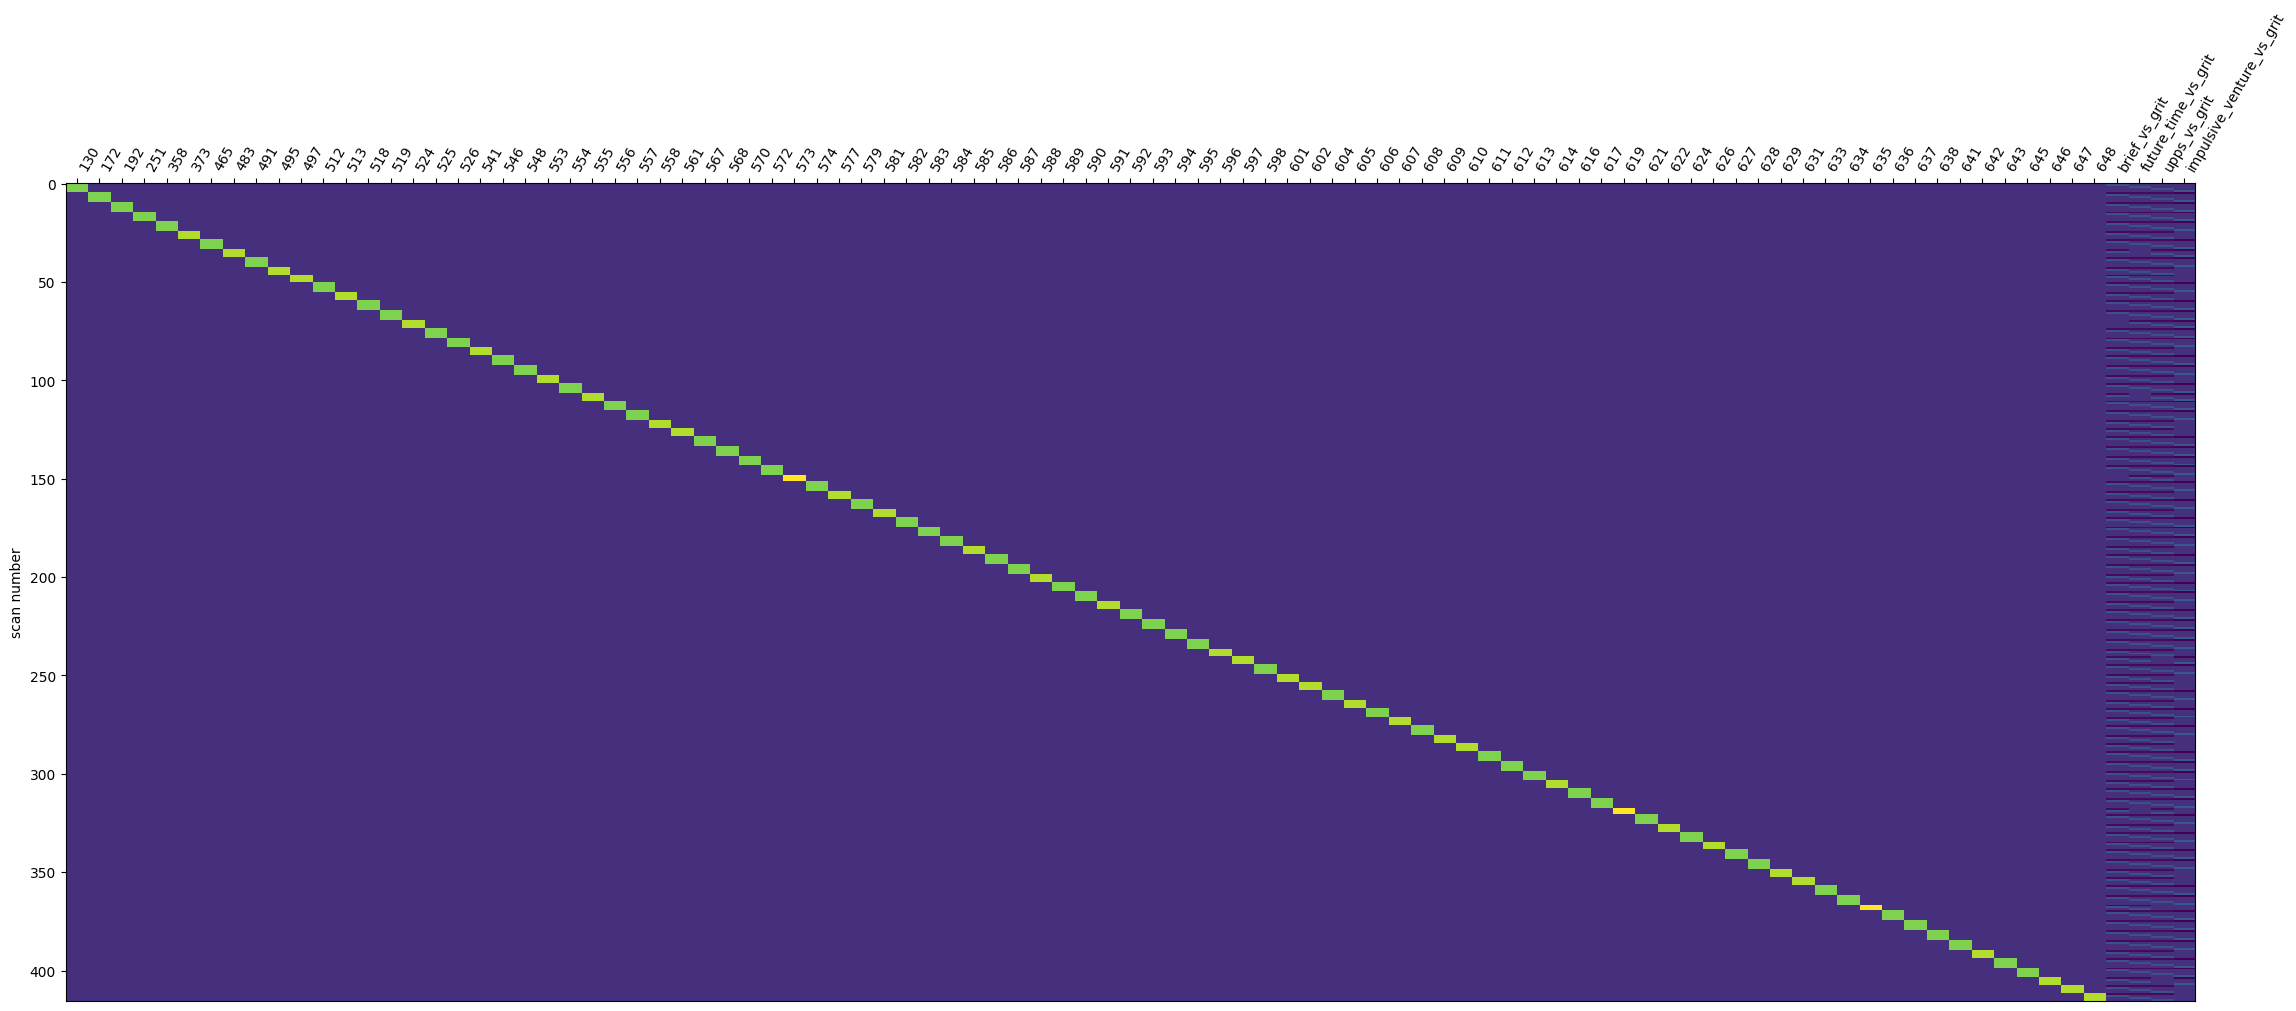

In [5]:
outlier_file = pd.read_csv(f"{root}/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/behavioral_measures_effect_size_outlier_analysis/percent_outlier_data.csv")

contrast_estimates = []
estimates_per_subject = {} # keep track of which questionnaire contrasts each subject has
subjects_to_remove = [] # we will remove subjects with no, or outlying, grit contrast, as this is our baseline questionnaire
for sub_id in sub_ids:
    sub_contrast_estimates = glob.glob(f'{root}/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/within_subject_results/*behavioral_measures_effect_size_sub_{sub_id}*')
    estimates_per_subject[sub_id] = []
    for questionnaire in questionnaires:
        contrast_present = False
        filename = f'{root}/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/within_subject_results/{questionnaire}_behavioral_measures_effect_size_sub_{sub_id}.nii.gz'
        if filename in sub_contrast_estimates:
            # don't include contrast estimates past the outlier threshold: > 8% voxels above +/- 3SD above subject-specific mean
            condition = (
                (outlier_file['subject_label'] == int(sub_id)) &
                (outlier_file['contrast_name'] == questionnaire)
            )
            outlier_percentage = outlier_file.loc[condition, 'image_outlier_percentage'].iloc[0]
            if outlier_percentage > 8:
                if questionnaire == 'grit':
                    subjects_to_remove.append(sub_id)
                    break
            else:
                contrast_estimates.append(filename)
                contrast_present = True
        estimates_per_subject[sub_id].append(contrast_present)
sub_ids = [sub for sub in sub_ids if sub not in subjects_to_remove]

# Make group mask
subject_masks = glob.glob(f'{root}/derivatives/fmriprep/sub-s*/ses-['
                        f'0-9]/func/*surveyMedley*space-MNI152NLin2009cAsym*mask*.nii.gz')
subject_masks = [mask for mask in subject_masks if any(id in mask for id in sub_ids)]
group_mask = masking.intersect_masks(subject_masks, threshold=1)
nf.save(group_mask, f'{root}/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/group_mask.nii.gz')

# Create design matrix
design_matrix = pd.DataFrame()
# Add subject indicator regressors
start = 0
for sub_id in sub_ids:
    one_indices = list(range(start, sum(estimates_per_subject[sub_id]) + start))
    start = one_indices[-1] + 1
    col = [1 if i in one_indices else 0 for i in range(len(contrast_estimates))]
    design_matrix[sub_id] = col
# Add questionnaire comparison regressors
comparison_list = ['brief_vs_grit', 'future_time_vs_grit', 'upps_vs_grit', 'impulsive_venture_vs_grit']
for i in range(4):
    col = []
    for sub_id in sub_ids:
        if (estimates_per_subject[sub_id][i + 1]) and (estimates_per_subject[sub_id][0]):
            sub_one_indices = [-1 if j == 0 else 1 if j == sum(estimates_per_subject[sub_id][:(i + 1)]) else 0 for j in range(sum(estimates_per_subject[sub_id]))]
        else:
            sub_one_indices = [0 for j in range(sum(estimates_per_subject[sub_id]))]
        col = col + sub_one_indices
    design_matrix[comparison_list[i]] = col

design_matrix_plot = plot_design_matrix(design_matrix)

In [6]:
t_contrasts = {
    "brief_vs_grit": "brief_vs_grit",
    "future_time_vs_grit": "future_time_vs_grit",
    "upps_vs_grit": "upps_vs_grit",
    "impulsive_venture_vs_grit": "impulsive_venture_vs_grit"
}

f_test = {"omnibus_f": ["brief_vs_grit", "future_time_vs_grit", "upps_vs_grit", "impulsive_venture_vs_grit"]}

script_path = setup_randomise_tfce(
    input_files=contrast_estimates,
    group_mask='/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/group_mask.nii.gz',
    output_directory='/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/output_glm_ftest',
    analysis_type="glm",
    num_perm=5000,
    design_matrix=design_matrix,
    contrast=t_contrasts,
    ftest=f_test,
    rename_output=True
)

Concatenating input files...
Created 4D file: /oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/output_glm_ftest/input_data4d.nii.gz


# Create design.grp file

In [7]:
grp_path = '/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/output_glm_ftest/design.grp'
with open(grp_path, 'w') as f:
  f.write('/NumWaves  1\n')
  f.write(f'/NumPoints  {len(contrast_estimates)}\n')
  f.write('\n')
  f.write('/Matrix\n')
  group_membership = 1
  for sub in sub_ids:
    for i in range(sum(estimates_per_subject[sub])):
      f.write(f'{group_membership}\n')
    group_membership += 1
     

Before running the randomise_call.sh script, amend the randomise call that is created to include a flag -e design.grp.

# Plot figures

We can plot the F-stat map thresholded at p < 0.05, and compare this with the F-stat map from the F-test that used all 40 questions.

In [4]:
from nilearn import plotting
import numpy as np

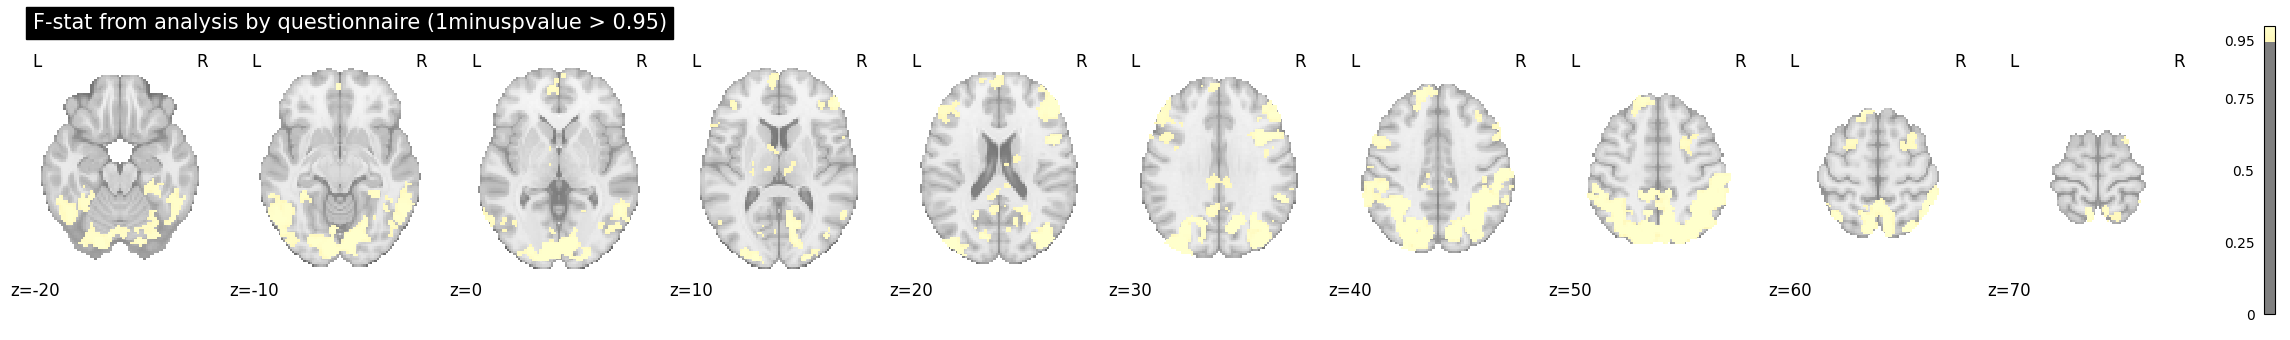

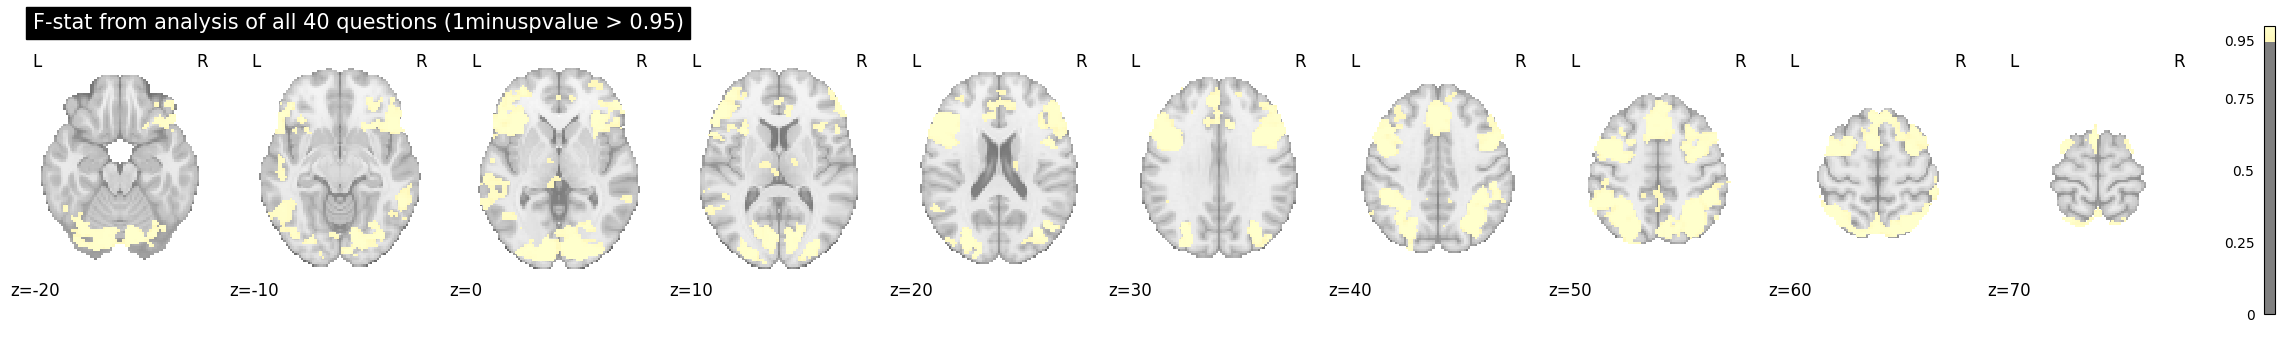

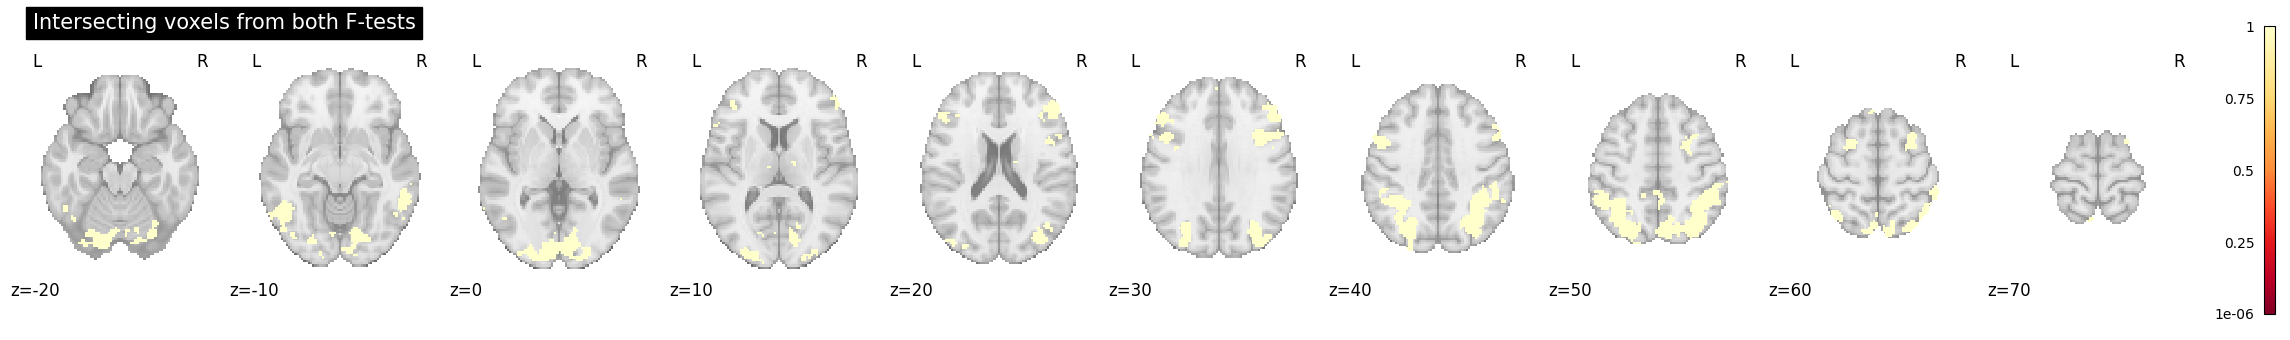

Overlap fraction: 0.249


In [5]:
z_slices = [-20, -10, 0, 10, 20, 30, 40, 50, 60, 70]
output_path = f'{root}/derivatives/survey_medley_results/within_subject_brain_behavior_by_questionnaire/output_glm_ftest'

# Plot F-stat p-value maps
fstat_pvalue_map = nf.load(f'{output_path}/glm_tfce_corrp_fstat1.nii.gz')
plotting.plot_stat_map(
            fstat_pvalue_map,
            display_mode='z',
            cut_coords=z_slices,
            colorbar=True,
            cmap='YlOrRd_r', 
            vmin=0, 
            vmax=1,
            threshold=0.95, 
            title=f'F-stat from analysis by questionnaire (1minuspvalue > 0.95)'
        )
plotting.show()

old_fstat_pvalue_map = nf.load(f'{root}/derivatives/survey_medley_results/within_subject_brain_behavior_analysis/output_twosided_onesample_t_test/onesample_2sided_tfce_corrp_fstat1.nii.gz')
plotting.plot_stat_map(
            old_fstat_pvalue_map,
            display_mode='z',
            cut_coords=z_slices,
            colorbar=True,
            cmap='YlOrRd_r', 
            vmin=0, 
            vmax=1,
            threshold=0.95, 
            title=f'F-stat from analysis of all 40 questions (1minuspvalue > 0.95)'
        )
plotting.show()

# Look at the overlap between the two maps
fstat_data = fstat_pvalue_map.get_fdata()
old_fstat_data = old_fstat_pvalue_map.get_fdata()

binary_fstat_data = (fstat_data > 0.95).astype(int)
binary_old_fstat_data = (old_fstat_data > 0.95).astype(int)
intersection = binary_fstat_data * binary_old_fstat_data
overlap_image = nf.Nifti1Image(intersection, fstat_pvalue_map.affine, fstat_pvalue_map.header)
plotting.plot_stat_map(
            overlap_image,
            display_mode='z',
            cut_coords=z_slices,
            colorbar=True,
            cmap='YlOrRd_r', 
            vmin=0, 
            vmax=1,
            title=f'Intersecting voxels from both F-tests'
        )
plotting.show()
overlap_fraction = np.sum(intersection) / np.sum((binary_fstat_data + binary_old_fstat_data) > 0)
print(f'Overlap fraction: {overlap_fraction:.3f}')

Also, try plotting the uncorrected t-stat maps

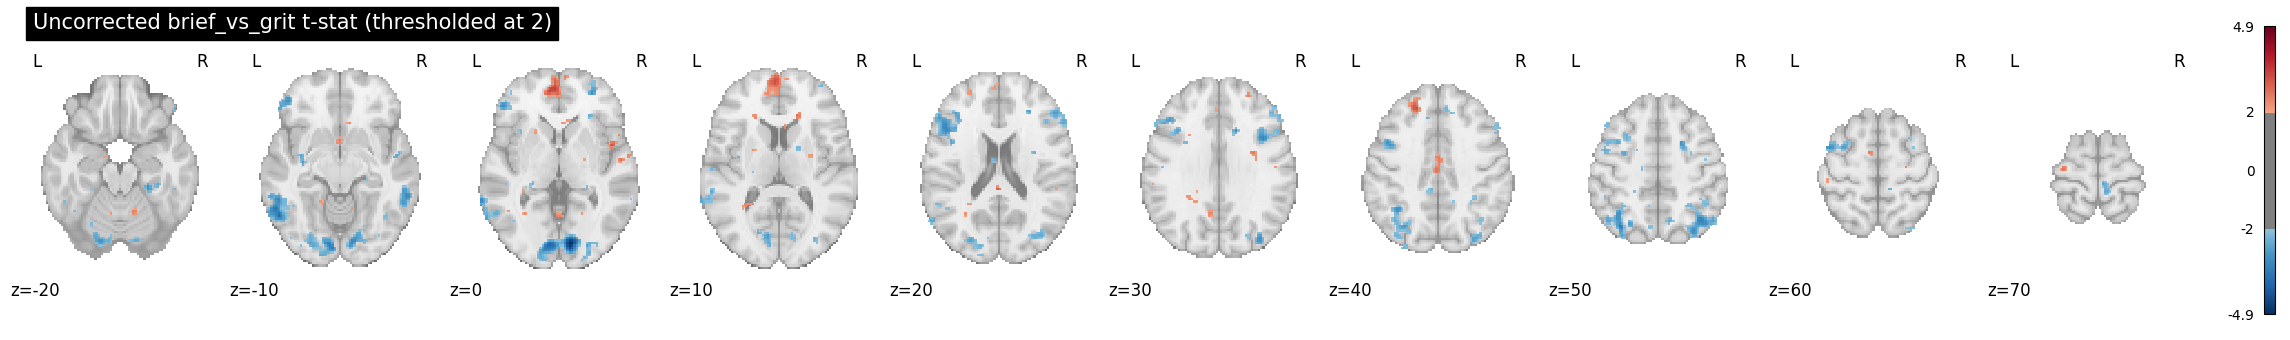

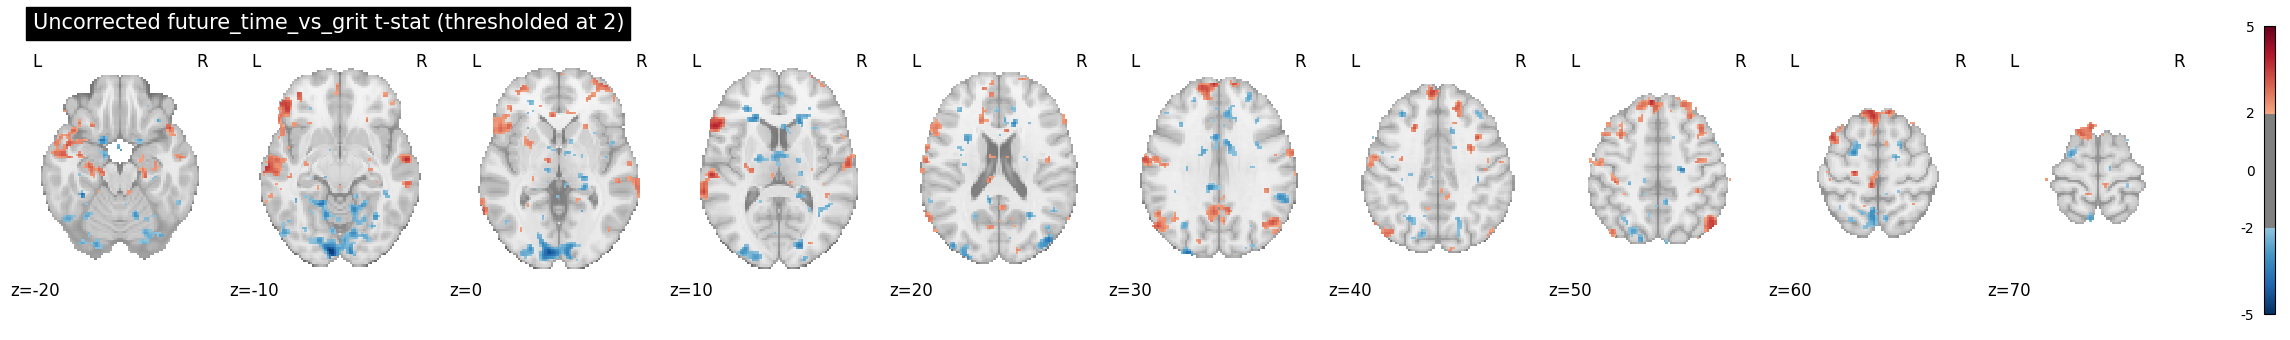

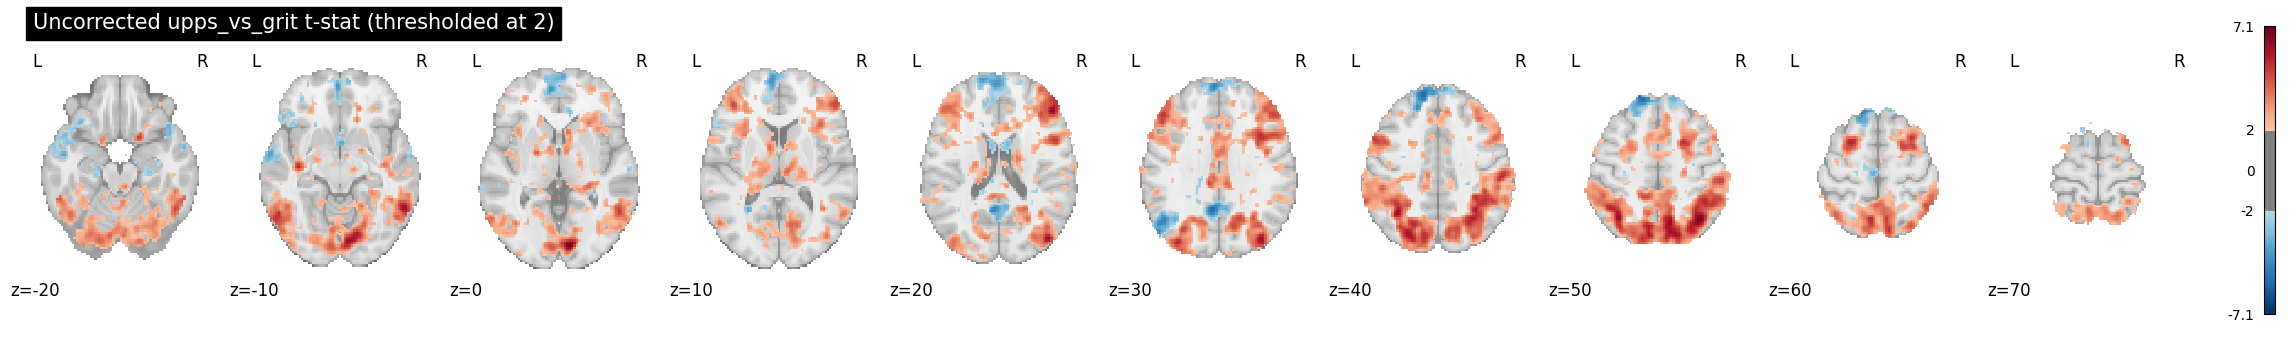

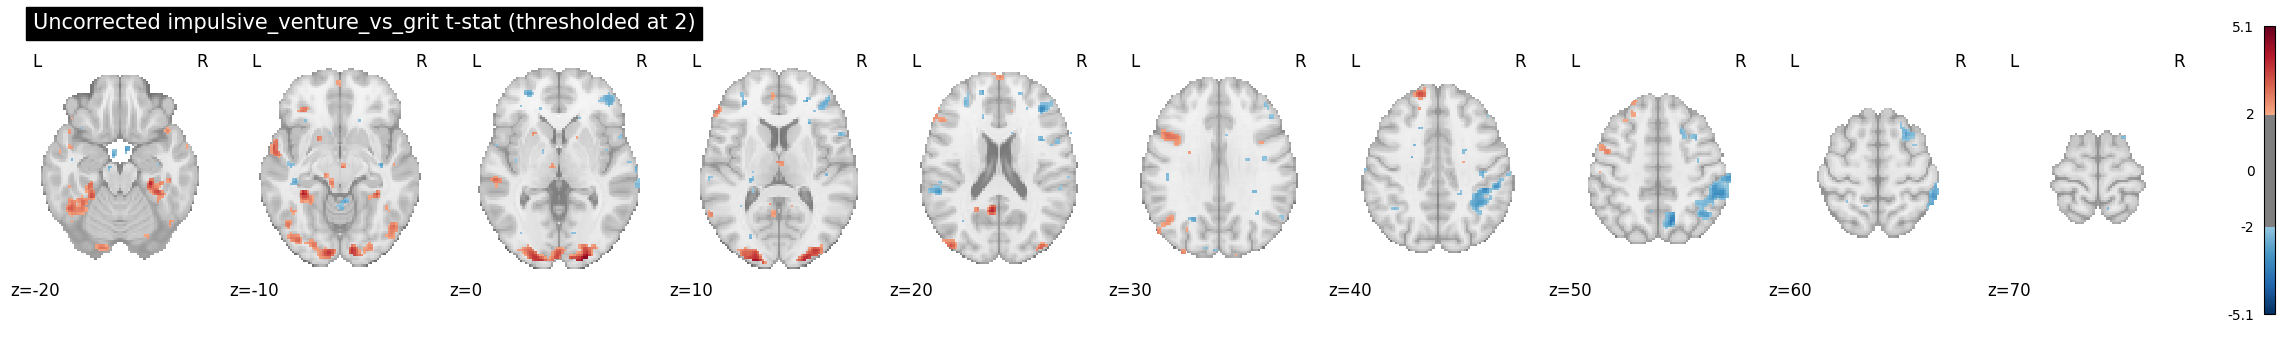

In [6]:
contrast_list = ['brief_vs_grit', 'future_time_vs_grit', 'upps_vs_grit', 'impulsive_venture_vs_grit']
for i in range(4):
  tstat_map = nf.load(f'{output_path}/glm_tstat{i + 1}.nii.gz')
  plotting.plot_stat_map(
            tstat_map,
            display_mode='z',
            cut_coords=z_slices,
            threshold=2.0, 
            colorbar=True,
            title=f'Uncorrected {contrast_list[i]} t-stat (thresholded at 2)'
        )
plotting.show()